In [0]:
# download google word2vec pretrained embedding 
!wget "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2019-02-12 06:37:15--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.164.109
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.164.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz.1’

GoogleNews-vectors- 100%[===================>]   1.53G  70.3MB/s    in 26s     

2019-02-12 06:37:41 (60.2 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz.1’ saved [1647046227/1647046227]



In [0]:
# Import Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from time import time
import pandas as pd
import numpy as np
# !pip install gensim
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
# Import Data
import nltk
nltk.download('stopwords')
TRAIN_CSV = '/content/drive/My Drive/Datasets/quora-question-pairs/train.csv'
TEST_CSV = '/content/drive/My Drive/Datasets/quora-question-pairs/test.csv'
# TEST1_CSV = '/content/drive/My Drive/Datasets/quora-question-pairs/testquestions/OwnTrainingData.csv'
EMBEDDING_FILE = '/content/GoogleNews-vectors-negative300.bin.gz'
MODEL_SAVING_DIR = '/content/'
LOG_DIR="/content/"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def text_to_word_list(text):
    ''' 
    Pre process and convert texts to a list of words 
    input: str
    output: list of cleaned word
    '''
    
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub("quikly","quickly", text)

    text = text.split()

    return text

In [0]:
# Create embeddings

vocabulary = {} # key is the word, value is the index
inverse_vocabulary = ['<unk>'] # value is the word, index is the index
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

# key is the word, value is a 300 dimensional vector for each word

word2vec.word_vec("test")[:10]

array([-0.14257812, -0.03686523,  0.13574219, -0.06201172,  0.07958984,
        0.01904297, -0.08154297, -0.12792969, -0.02954102,  0.23632812],
      dtype=float32)

In [0]:
# Read the train and test data

train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
test1_df = pd.read_csv(TEST1_CSV, names=['question1', 'question2', 'is_duplicate'], header=None)
train_df.head()
print("load done")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


load done


In [0]:
test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


(array([1.2000e+02, 0.0000e+00, 7.9600e+02, 0.0000e+00, 5.1780e+03,
        0.0000e+00, 1.3172e+04, 0.0000e+00, 2.6239e+04, 0.0000e+00,
        4.2694e+04, 0.0000e+00, 5.3076e+04, 0.0000e+00, 5.2240e+04,
        0.0000e+00, 4.4186e+04, 0.0000e+00, 3.4520e+04, 0.0000e+00,
        2.6351e+04, 0.0000e+00, 2.0407e+04, 0.0000e+00, 1.5814e+04,
        0.0000e+00, 1.2744e+04, 0.0000e+00, 1.1039e+04, 0.0000e+00,
        8.7920e+03, 0.0000e+00, 6.7340e+03, 0.0000e+00, 5.1920e+03,
        0.0000e+00, 4.3630e+03, 0.0000e+00, 3.6580e+03, 0.0000e+00,
        3.1080e+03, 0.0000e+00, 2.7780e+03, 0.0000e+00, 2.3750e+03,
        0.0000e+00, 1.8470e+03, 0.0000e+00, 1.6180e+03, 0.0000e+00,
        0.0000e+00, 1.2630e+03, 0.0000e+00, 8.3500e+02, 0.0000e+00,
        6.2400e+02, 0.0000e+00, 4.4600e+02, 0.0000e+00, 3.4200e+02,
        0.0000e+00, 2.7100e+02, 0.0000e+00, 2.2200e+02, 0.0000e+00,
        1.6900e+02, 0.0000e+00, 1.6600e+02, 0.0000e+00, 1.3300e+02,
        0.0000e+00, 1.0000e+02, 0.0000e+00, 9.20

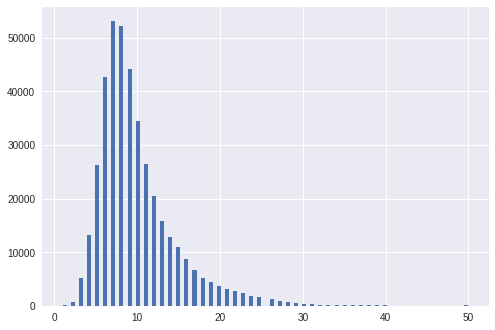

In [0]:
# Determine the distribution of the length of questions 

import matplotlib.pyplot as plt

plt.hist(train_df.question1.map(lambda x: len(str(x).split())).values, bins = 100)

In [0]:
stops = set(stopwords.words('english'))
outside_words=set()
from tqdm import tqdm
questions_cols = ['question1', 'question2']
for dataset in [train_df, test_df, test1_df]:
  for index,row in (dataset.iterrows()):
    for question in questions_cols:
      
      q2n = [] 
      count_ = 0
      # convert a question to a integer list, the integer corresponding to the index in the small vocabulary
      for word in text_to_word_list(row[question]):
        
        if word not in word2vec.vocab:
          outside_words.add(word)
          continue
          
        # limit the length to 50, this decreased the time to train an epoch from more than 1 hour to 20 minutes.
        if count_ >= 50 :
          continue
        count_ +=1
        
        if word not in vocabulary:
          vocabulary[word] = len(inverse_vocabulary)
          q2n.append(len(inverse_vocabulary))
          inverse_vocabulary.append(word)
        else:
          q2n.append(vocabulary[word])
      
      
      dataset.set_value(index,question,q2n)

embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary)+1, embedding_dim)
embeddings[0] = 0
# by using the code above, the first vector of embeddings are all 0.
embeddings[0]

      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [0]:
for word, index in tqdm(vocabulary.items()):
  if word in word2vec.vocab:
    embeddings[index] = word2vec.word_vec(word)
    
del word2vec
# calculate the max length 

max_seq_length = max(train_df.question1.map(lambda x:len(x)).max(),
                    train_df.question2.map(lambda x:len(x)).max(),
                    test_df.question1.map(lambda x:len(x)).max(),
                    test_df.question2.map(lambda x:len(x)).max(),
                    test1_df.question1.map(lambda x:len(x)).max(),
                    test1_df.question2.map(lambda x:len(x)).max())
# max_seq_length = 50
print(max_seq_length)

  0%|          | 0/227 [00:00<?, ?it/s]


NameError: ignored

In [0]:
num_samples = len(train_df)
validation_size = (int)(num_samples * 0.2)
training_size = len(train_df) - validation_size 
questions_cols = ['question1', 'question2']
X = train_df[questions_cols]
X_test = test_df[questions_cols]
# X_test1 = test1_df[questions_cols]
Y = train_df['is_duplicate']
# Y_test1 = test1_df['is_duplicate']

# train test split x and y into train and validation
X_train, X_validation, Y_train, Y_validation = train_test_split(X,Y,test_size = validation_size)

# Split to dicts
X_test = {'left':X_test.question1,'right':X_test.question2}
# X_test1 = {'left':X_test1.question1,'right':X_test1.question2}
X_train = {'left':X_train.question1,'right':X_train.question2}
X_validation = {'left':X_validation.question1,'right':X_validation.question2}
#X_test = {'left':X_test.question1,'right':X_test.question2}

# fetch Ys
Y_train = Y_train.values
# Y_test1 = Y_test1.values
Y_test = Y_validation.values

# zero padding

for dataset, side in itertools.product([X_test, X_test1, X_train, X_validation],['left','right']):
  dataset[side] = pad_sequences(dataset[side], maxlen = max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [0]:
import keras
import tensorflow as tf

n_hidden = 50
gradient_clipping_norm  = 1.25
# what is gradient clipping norm?
# https://www.quora.com/What-is-gradient-clipping-and-why-is-it-necessary

batch_size = 64
n_epoch = 25

def exponent_neg_manhattan_distance(left, right):
  return K.exp(-K.sum(K.abs(left-right),axis = 1, keepdims = True))

# Input layer
left_input = Input(shape=(max_seq_length,), dtype="int32")
right_input = Input(shape=(max_seq_length,), dtype="int32")

# Embedding layer
embedding_layer = Embedding(
    input_dim = len(embeddings),
    output_dim = embedding_dim, 
    weights= [embeddings],
    input_length=max_seq_length,
    trainable=False)

encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# LSTM Layer
shared_lstm = LSTM(n_hidden)
left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculate the Manhattan Distance of the two outputs
malstm_distance = Lambda(function = lambda x:exponent_neg_manhattan_distance(x[0],x[1]),\
                         output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

malstm = Model([left_input, right_input], [malstm_distance])
malstm.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      17612100    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None

In [0]:
optimizer = Adadelta(clipnorm = gradient_clipping_norm)
# What is Adadelta optimizer?
# https://keras.io/optimizers/#adadelta
# the advantage of this is we dont need to set a learning-rate for the optimizer. 
# Adadelta is a more robust extension of Adagrad that adapts learning rates based 
# on a moving window of gradient updates, instead of accumulating all past gradients.
# https://www.quora.com/What-is-gradient-clipping-and-why-is-it-necessary
# here, we just need to know, gradient clipping can make the converge faster, it's helpful to limit the gradient to control the exploding of gradient

In [0]:
malstm.load_weights('/content/drive/My Drive/Datasets/quora-question-pairs/model_weights.h5')

In [0]:
malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir=LOG_DIR.format(time()))

filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, mode='max')
callbacks_list = [checkpoint]

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,\
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # Remove the CWD from sys.path while we load stuff.


Train on 323432 samples, validate on 80858 samples
Epoch 1/25
323432/323432 [==============================] - 1270s 4ms/step - loss: 0.1808 - acc: 0.7307 - val_loss: 0.1701 - val_acc: 0.7483

Epoch 00001: saving model to weights.hdf5
Epoch 2/25
323432/323432 [==============================] - 1232s 4ms/step - loss: 0.1635 - acc: 0.7665 - val_loss: 0.1608 - val_acc: 0.7742

Epoch 00002: saving model to weights.hdf5
Epoch 3/25
323432/323432 [==============================] - 1217s 4ms/step - loss: 0.1565 - acc: 0.7809 - val_loss: 0.1561 - val_acc: 0.7784

Epoch 00003: saving model to weights.hdf5
Epoch 4/25
323432/323432 [==============================] - 1212s 4ms/step - loss: 0.1519 - acc: 0.7897 - val_loss: 0.1527 - val_acc: 0.7843

Epoch 00004: saving model to weights.hdf5
Epoch 5/25
323432/323432 [==============================] - 1239s 4ms/step - loss: 0.1485 - acc: 0.7953 - val_loss: 0.1507 - val_acc: 0.7928

Epoch 00005: saving model to weights.hdf5
Epoch 6/25
323432/323432 [===

MessageError: ignored

In [0]:
sub = pd.DataFrame()
p_test = malstm.predict([X_test['left'][0:10],X_test['right'][0:10]])

p_test

array([[0.07441217],
       [0.33911413],
       [0.4280171 ],
       [0.03815874],
       [0.702497  ],
       [0.02664997],
       [0.64101887],
       [0.6607826 ],
       [0.47963896],
       [0.02368323]], dtype=float32)

In [0]:
from google.colab import files
malstm.save_weights("model_weights.h5")
files.download('model_weights.h5')

In [0]:
files.download('model.h5')